In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transformations with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.9, 1.0),      # very mild crop
        ratio=(0.95, 1.05)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.05,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Validation and test transformations without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type label encoding
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/data/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/data/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/data/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        ax2.set_xlabel('Epoch')

# Model Definitions

In [12]:
def create_coatnet_model(model_type='0', num_classes=4, pretrained=True):
    """
    Create CoAtNet (Convolution and Attention Network) model
    
    Args:
        model_type (str): Model variant - '0', '1', '2', '3', '4'
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: CoAtNet model
    """
    
    model = timm.create_model(f'coatnet_{model_type}_rw_224.sw_in1k', pretrained=pretrained, num_classes=num_classes)
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train CoAtNet-0

Training CoAtNet-0


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.55it/s, Loss=1.4723, Acc=0.3084]


Train Loss: 1.4723 Acc: 0.3084 Macro-F1: 0.2859


Val : 100%|██████████| 10/10 [00:01<00:00,  5.47it/s, Loss=1.0713, Acc=0.4375]


Val Loss: 1.0713 Acc: 0.4375 Macro-F1: 0.3519
✓ New best model saved with validation macro-F1: 0.3519

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=1.0861, Acc=0.5016]


Train Loss: 1.0861 Acc: 0.5016 Macro-F1: 0.4504


Val : 100%|██████████| 10/10 [00:01<00:00,  7.00it/s, Loss=1.5411, Acc=0.4671]


Val Loss: 1.5411 Acc: 0.4671 Macro-F1: 0.4112
✓ New best model saved with validation macro-F1: 0.4112

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=1.0658, Acc=0.5288]


Train Loss: 1.0658 Acc: 0.5288 Macro-F1: 0.4738


Val : 100%|██████████| 10/10 [00:01<00:00,  7.23it/s, Loss=0.8345, Acc=0.5493]


Val Loss: 0.8345 Acc: 0.5493 Macro-F1: 0.4325
✓ New best model saved with validation macro-F1: 0.4325

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=0.8919, Acc=0.5773]


Train Loss: 0.8919 Acc: 0.5773 Macro-F1: 0.5348


Val : 100%|██████████| 10/10 [00:01<00:00,  6.74it/s, Loss=0.7998, Acc=0.5658]


Val Loss: 0.7998 Acc: 0.5658 Macro-F1: 0.5213
✓ New best model saved with validation macro-F1: 0.5213

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.89it/s, Loss=0.8005, Acc=0.6530]


Train Loss: 0.8005 Acc: 0.6530 Macro-F1: 0.6193


Val : 100%|██████████| 10/10 [00:01<00:00,  7.22it/s, Loss=0.8022, Acc=0.6711]


Val Loss: 0.8022 Acc: 0.6711 Macro-F1: 0.6364
✓ New best model saved with validation macro-F1: 0.6364

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=0.7777, Acc=0.7138]


Train Loss: 0.7777 Acc: 0.7138 Macro-F1: 0.6749


Val : 100%|██████████| 10/10 [00:01<00:00,  7.07it/s, Loss=1.1051, Acc=0.5395]


Val Loss: 1.1051 Acc: 0.5395 Macro-F1: 0.5226

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=0.7471, Acc=0.6900]


Train Loss: 0.7471 Acc: 0.6900 Macro-F1: 0.6520


Val : 100%|██████████| 10/10 [00:01<00:00,  7.19it/s, Loss=0.6503, Acc=0.7467]


Val Loss: 0.6503 Acc: 0.7467 Macro-F1: 0.7451
✓ New best model saved with validation macro-F1: 0.7451

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=0.5323, Acc=0.7887]


Train Loss: 0.5323 Acc: 0.7887 Macro-F1: 0.7825


Val : 100%|██████████| 10/10 [00:01<00:00,  7.20it/s, Loss=0.5023, Acc=0.7796]


Val Loss: 0.5023 Acc: 0.7796 Macro-F1: 0.7581
✓ New best model saved with validation macro-F1: 0.7581

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.89it/s, Loss=0.4725, Acc=0.8331]


Train Loss: 0.4725 Acc: 0.8331 Macro-F1: 0.8044


Val : 100%|██████████| 10/10 [00:01<00:00,  7.17it/s, Loss=0.3885, Acc=0.8553]


Val Loss: 0.3885 Acc: 0.8553 Macro-F1: 0.8401
✓ New best model saved with validation macro-F1: 0.8401

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=0.4239, Acc=0.8446]


Train Loss: 0.4239 Acc: 0.8446 Macro-F1: 0.8283


Val : 100%|██████████| 10/10 [00:01<00:00,  7.20it/s, Loss=0.3970, Acc=0.8520]


Val Loss: 0.3970 Acc: 0.8520 Macro-F1: 0.8335

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.88it/s, Loss=0.4014, Acc=0.8569]


Train Loss: 0.4014 Acc: 0.8569 Macro-F1: 0.8389


Val : 100%|██████████| 10/10 [00:01<00:00,  7.12it/s, Loss=0.3694, Acc=0.8684]


Val Loss: 0.3694 Acc: 0.8684 Macro-F1: 0.8500
✓ New best model saved with validation macro-F1: 0.8500

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=0.3376, Acc=0.8775]


Train Loss: 0.3376 Acc: 0.8775 Macro-F1: 0.8669


Val : 100%|██████████| 10/10 [00:01<00:00,  7.07it/s, Loss=0.3393, Acc=0.8750]


Val Loss: 0.3393 Acc: 0.8750 Macro-F1: 0.8611
✓ New best model saved with validation macro-F1: 0.8611

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.88it/s, Loss=0.3354, Acc=0.8758]


Train Loss: 0.3354 Acc: 0.8758 Macro-F1: 0.8697


Val : 100%|██████████| 10/10 [00:01<00:00,  7.04it/s, Loss=0.3447, Acc=0.8816]


Val Loss: 0.3447 Acc: 0.8816 Macro-F1: 0.8547

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=0.3050, Acc=0.8849]


Train Loss: 0.3050 Acc: 0.8849 Macro-F1: 0.8730


Val : 100%|██████████| 10/10 [00:01<00:00,  7.19it/s, Loss=0.2630, Acc=0.9178]


Val Loss: 0.2630 Acc: 0.9178 Macro-F1: 0.8979
✓ New best model saved with validation macro-F1: 0.8979

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.89it/s, Loss=0.3003, Acc=0.9013]


Train Loss: 0.3003 Acc: 0.9013 Macro-F1: 0.8964


Val : 100%|██████████| 10/10 [00:01<00:00,  7.04it/s, Loss=0.2797, Acc=0.9112]


Val Loss: 0.2797 Acc: 0.9112 Macro-F1: 0.8944

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.89it/s, Loss=0.2635, Acc=0.9112]


Train Loss: 0.2635 Acc: 0.9112 Macro-F1: 0.9010


Val : 100%|██████████| 10/10 [00:01<00:00,  7.06it/s, Loss=0.2697, Acc=0.9112]


Val Loss: 0.2697 Acc: 0.9112 Macro-F1: 0.8882

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=0.2637, Acc=0.8997]


Train Loss: 0.2637 Acc: 0.8997 Macro-F1: 0.8860


Val : 100%|██████████| 10/10 [00:01<00:00,  7.17it/s, Loss=0.2856, Acc=0.9079]


Val Loss: 0.2856 Acc: 0.9079 Macro-F1: 0.8881

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.90it/s, Loss=0.2802, Acc=0.9046]


Train Loss: 0.2802 Acc: 0.9046 Macro-F1: 0.8859


Val : 100%|██████████| 10/10 [00:01<00:00,  7.10it/s, Loss=0.3005, Acc=0.8914]


Val Loss: 0.3005 Acc: 0.8914 Macro-F1: 0.8637

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.89it/s, Loss=0.2626, Acc=0.9079]


Train Loss: 0.2626 Acc: 0.9079 Macro-F1: 0.8915


Val : 100%|██████████| 10/10 [00:01<00:00,  7.14it/s, Loss=0.2828, Acc=0.8980]


Val Loss: 0.2828 Acc: 0.8980 Macro-F1: 0.8714
Early stopping triggered after 19 epochs
Training complete in 4m 42s
Best validation macro-F1: 0.8979
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.15it/s]


Test Accuracy: 45.50%
Test Loss: 2.1737

Classification Report:
              precision    recall  f1-score   support

         HGC       0.55      0.64      0.59        74
         LGC       0.14      0.09      0.11        53
         NST       0.75      0.57      0.65        37
         NTL       0.33      0.52      0.40        25

    accuracy                           0.46       189
   macro avg       0.44      0.45      0.44       189
weighted avg       0.45      0.46      0.44       189


Confusion Matrix:
[[47 21  6  0]
 [27  5  0 21]
 [ 2  8 21  6]
 [ 9  2  1 13]]

ROC-AUC Scores:
Macro-average AUC: 0.6805
Micro-average AUC: 0.6868
HGC AUC: 0.7684
LGC AUC: 0.3066
NST AUC: 0.8403
NTL AUC: 0.8066


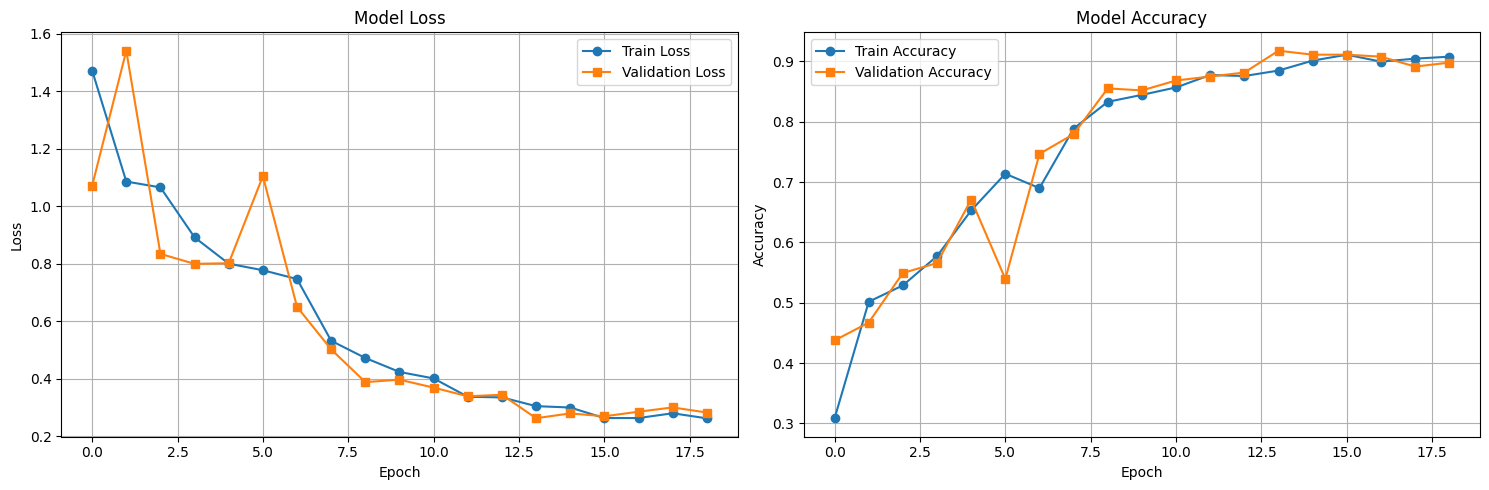

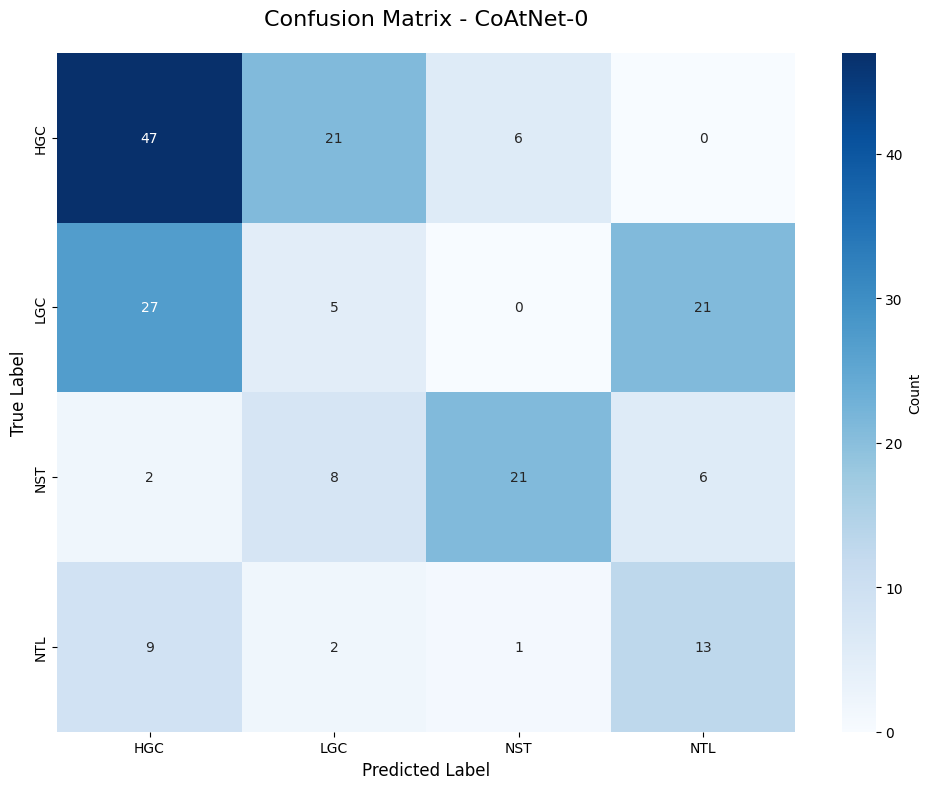

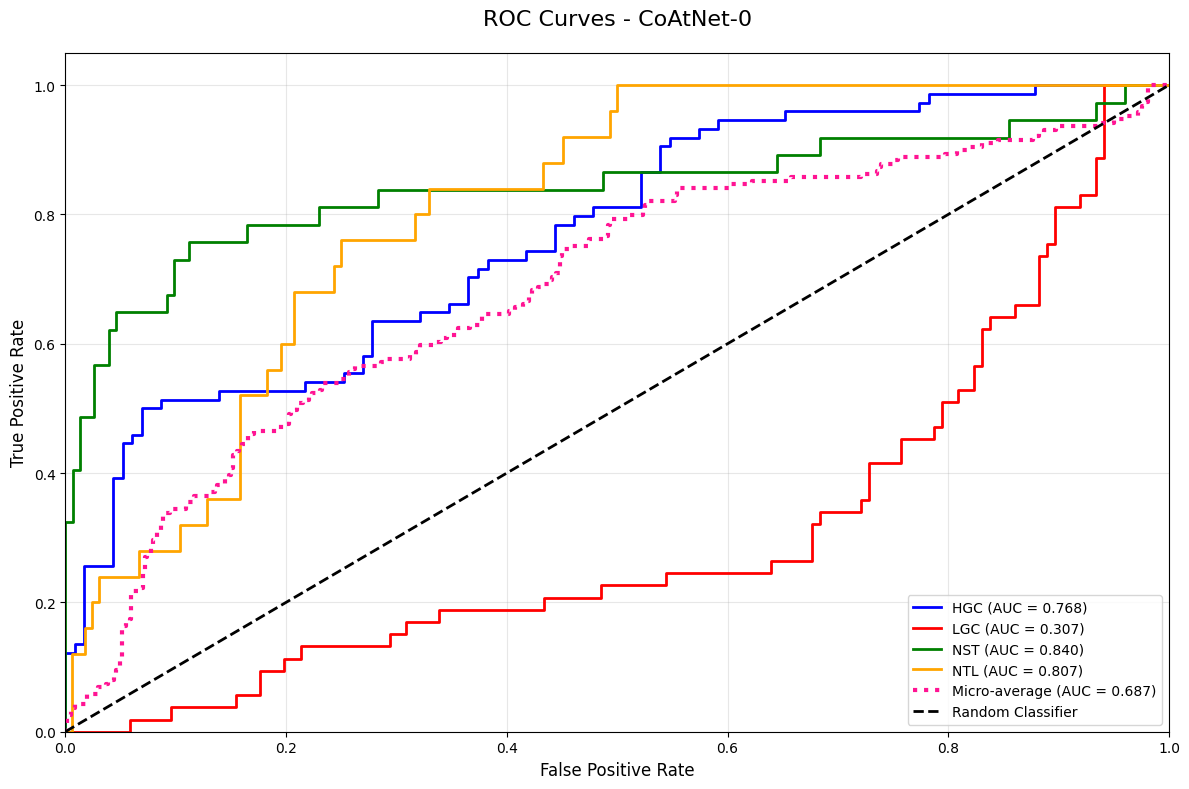


CoAtNet-0 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training CoAtNet-0")
print("=" * 80)

# Create model
coatnet_0 = create_coatnet_model(
    model_type='0',
    num_classes=4,
    pretrained=True
)

# Create trainer
trainer_coatnet_0 = ModelTrainer(coatnet_0, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_coatnet_0 = trainer_coatnet_0.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="CoAtNet-0")

# Plot training history
trainer_coatnet_0.plot_training_history(save_path='coatnet_0_training_history.png')

# Evaluate model
results_coatnet_0 = trainer_coatnet_0.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_coatnet_0['confusion_matrix'], class_names, 'CoAtNet-0',
                      save_path='coatnet_0_confusion_matrix.png')

# Plot ROC curves
roc_auc_coatnet_0 = plot_roc_curves(results_coatnet_0['labels'], results_coatnet_0['probabilities'], class_names, 'CoAtNet-0',
                                     save_path='coatnet_0_roc_curves.png')

# Store results
results_coatnet_0['model_name'] = 'CoAtNet-0'
results_coatnet_0['roc_auc'] = roc_auc_coatnet_0
all_results.append(results_coatnet_0)

print("\nCoAtNet-0 training and evaluation complete!")

## Train CoAtNet-1

Training CoAtNet-1


model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=1.5492, Acc=0.2738]


Train Loss: 1.5492 Acc: 0.2738 Macro-F1: 0.2582


Val : 100%|██████████| 10/10 [00:02<00:00,  4.74it/s, Loss=1.3871, Acc=0.2993]


Val Loss: 1.3871 Acc: 0.2993 Macro-F1: 0.2749
✓ New best model saved with validation macro-F1: 0.2749

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.68it/s, Loss=1.3609, Acc=0.3520]


Train Loss: 1.3609 Acc: 0.3520 Macro-F1: 0.3337


Val : 100%|██████████| 10/10 [00:02<00:00,  4.75it/s, Loss=1.2345, Acc=0.4079]


Val Loss: 1.2345 Acc: 0.4079 Macro-F1: 0.2621

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=1.2053, Acc=0.4317]


Train Loss: 1.2053 Acc: 0.4317 Macro-F1: 0.3874


Val : 100%|██████████| 10/10 [00:02<00:00,  4.77it/s, Loss=1.7524, Acc=0.3026]


Val Loss: 1.7524 Acc: 0.3026 Macro-F1: 0.1531

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=1.1097, Acc=0.4901]


Train Loss: 1.1097 Acc: 0.4901 Macro-F1: 0.4539


Val : 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, Loss=1.0287, Acc=0.5362]


Val Loss: 1.0287 Acc: 0.5362 Macro-F1: 0.4672
✓ New best model saved with validation macro-F1: 0.4672

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=1.0090, Acc=0.5255]


Train Loss: 1.0090 Acc: 0.5255 Macro-F1: 0.4953


Val : 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, Loss=1.0848, Acc=0.4211]


Val Loss: 1.0848 Acc: 0.4211 Macro-F1: 0.2660

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.9231, Acc=0.5288]


Train Loss: 0.9231 Acc: 0.5288 Macro-F1: 0.5022


Val : 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, Loss=1.2389, Acc=0.3717]


Val Loss: 1.2389 Acc: 0.3717 Macro-F1: 0.3054

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.8672, Acc=0.5403]


Train Loss: 0.8672 Acc: 0.5403 Macro-F1: 0.5213


Val : 100%|██████████| 10/10 [00:02<00:00,  4.72it/s, Loss=1.0745, Acc=0.3882]


Val Loss: 1.0745 Acc: 0.3882 Macro-F1: 0.3796

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.7307, Acc=0.5699]


Train Loss: 0.7307 Acc: 0.5699 Macro-F1: 0.5470


Val : 100%|██████████| 10/10 [00:02<00:00,  4.70it/s, Loss=0.7639, Acc=0.5395]


Val Loss: 0.7639 Acc: 0.5395 Macro-F1: 0.5202
✓ New best model saved with validation macro-F1: 0.5202

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.65it/s, Loss=0.6446, Acc=0.6472]


Train Loss: 0.6446 Acc: 0.6472 Macro-F1: 0.6331


Val : 100%|██████████| 10/10 [00:02<00:00,  4.72it/s, Loss=0.7667, Acc=0.5395]


Val Loss: 0.7667 Acc: 0.5395 Macro-F1: 0.5235
✓ New best model saved with validation macro-F1: 0.5235

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.5737, Acc=0.7311]


Train Loss: 0.5737 Acc: 0.7311 Macro-F1: 0.7141


Val : 100%|██████████| 10/10 [00:02<00:00,  4.80it/s, Loss=0.7041, Acc=0.6283]


Val Loss: 0.7041 Acc: 0.6283 Macro-F1: 0.6041
✓ New best model saved with validation macro-F1: 0.6041

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.5250, Acc=0.7706]


Train Loss: 0.5250 Acc: 0.7706 Macro-F1: 0.7471


Val : 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, Loss=0.6926, Acc=0.6842]


Val Loss: 0.6926 Acc: 0.6842 Macro-F1: 0.6563
✓ New best model saved with validation macro-F1: 0.6563

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.5013, Acc=0.7878]


Train Loss: 0.5013 Acc: 0.7878 Macro-F1: 0.7665


Val : 100%|██████████| 10/10 [00:02<00:00,  4.75it/s, Loss=0.6119, Acc=0.7303]


Val Loss: 0.6119 Acc: 0.7303 Macro-F1: 0.7056
✓ New best model saved with validation macro-F1: 0.7056

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.4684, Acc=0.7895]


Train Loss: 0.4684 Acc: 0.7895 Macro-F1: 0.7733


Val : 100%|██████████| 10/10 [00:02<00:00,  4.69it/s, Loss=0.6282, Acc=0.7270]


Val Loss: 0.6282 Acc: 0.7270 Macro-F1: 0.7042

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.4378, Acc=0.8183]


Train Loss: 0.4378 Acc: 0.8183 Macro-F1: 0.7963


Val : 100%|██████████| 10/10 [00:02<00:00,  4.75it/s, Loss=0.4484, Acc=0.8092]


Val Loss: 0.4484 Acc: 0.8092 Macro-F1: 0.8188
✓ New best model saved with validation macro-F1: 0.8188

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.3641, Acc=0.8528]


Train Loss: 0.3641 Acc: 0.8528 Macro-F1: 0.8561


Val : 100%|██████████| 10/10 [00:02<00:00,  4.73it/s, Loss=0.4353, Acc=0.8257]


Val Loss: 0.4353 Acc: 0.8257 Macro-F1: 0.8164

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.3542, Acc=0.8561]


Train Loss: 0.3542 Acc: 0.8561 Macro-F1: 0.8541


Val : 100%|██████████| 10/10 [00:02<00:00,  4.65it/s, Loss=0.4698, Acc=0.7961]


Val Loss: 0.4698 Acc: 0.7961 Macro-F1: 0.7765

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.3442, Acc=0.8586]


Train Loss: 0.3442 Acc: 0.8586 Macro-F1: 0.8465


Val : 100%|██████████| 10/10 [00:02<00:00,  4.77it/s, Loss=0.4449, Acc=0.8191]


Val Loss: 0.4449 Acc: 0.8191 Macro-F1: 0.7990

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.68it/s, Loss=0.3554, Acc=0.8594]


Train Loss: 0.3554 Acc: 0.8594 Macro-F1: 0.8513


Val : 100%|██████████| 10/10 [00:02<00:00,  4.59it/s, Loss=0.4113, Acc=0.8388]


Val Loss: 0.4113 Acc: 0.8388 Macro-F1: 0.8219
✓ New best model saved with validation macro-F1: 0.8219

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.3319, Acc=0.8643]


Train Loss: 0.3319 Acc: 0.8643 Macro-F1: 0.8567


Val : 100%|██████████| 10/10 [00:02<00:00,  4.75it/s, Loss=0.4510, Acc=0.8224]


Val Loss: 0.4510 Acc: 0.8224 Macro-F1: 0.8028

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.3312, Acc=0.8791]


Train Loss: 0.3312 Acc: 0.8791 Macro-F1: 0.8641


Val : 100%|██████████| 10/10 [00:02<00:00,  4.76it/s, Loss=0.4231, Acc=0.8388]


Val Loss: 0.4231 Acc: 0.8388 Macro-F1: 0.8180

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.68it/s, Loss=0.3181, Acc=0.8676]


Train Loss: 0.3181 Acc: 0.8676 Macro-F1: 0.8589


Val : 100%|██████████| 10/10 [00:02<00:00,  4.74it/s, Loss=0.4003, Acc=0.8487]


Val Loss: 0.4003 Acc: 0.8487 Macro-F1: 0.8335
✓ New best model saved with validation macro-F1: 0.8335

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.3379, Acc=0.8544]


Train Loss: 0.3379 Acc: 0.8544 Macro-F1: 0.8480


Val : 100%|██████████| 10/10 [00:02<00:00,  4.74it/s, Loss=0.4236, Acc=0.8289]


Val Loss: 0.4236 Acc: 0.8289 Macro-F1: 0.8112

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.3118, Acc=0.8725]


Train Loss: 0.3118 Acc: 0.8725 Macro-F1: 0.8656


Val : 100%|██████████| 10/10 [00:02<00:00,  4.65it/s, Loss=0.4408, Acc=0.8092]


Val Loss: 0.4408 Acc: 0.8092 Macro-F1: 0.7867

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.69it/s, Loss=0.3192, Acc=0.8701]


Train Loss: 0.3192 Acc: 0.8701 Macro-F1: 0.8662


Val : 100%|██████████| 10/10 [00:02<00:00,  4.74it/s, Loss=0.3899, Acc=0.8487]


Val Loss: 0.3899 Acc: 0.8487 Macro-F1: 0.8339
✓ New best model saved with validation macro-F1: 0.8339

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.68it/s, Loss=0.3194, Acc=0.8684]


Train Loss: 0.3194 Acc: 0.8684 Macro-F1: 0.8620


Val : 100%|██████████| 10/10 [00:02<00:00,  4.68it/s, Loss=0.4358, Acc=0.8257]


Val Loss: 0.4358 Acc: 0.8257 Macro-F1: 0.8050

Training complete in 10m 21s
Best validation macro-F1: 0.8339
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.01it/s]


Test Accuracy: 48.68%
Test Loss: 1.7267

Classification Report:
              precision    recall  f1-score   support

         HGC       0.80      0.72      0.76        74
         LGC       0.09      0.08      0.08        53
         NST       0.92      0.59      0.72        37
         NTL       0.23      0.52      0.32        25

    accuracy                           0.49       189
   macro avg       0.51      0.48      0.47       189
weighted avg       0.55      0.49      0.50       189


Confusion Matrix:
[[53 16  1  4]
 [13  4  1 35]
 [ 0 11 22  4]
 [ 0 12  0 13]]

ROC-AUC Scores:
Macro-average AUC: 0.7171
Micro-average AUC: 0.7476
HGC AUC: 0.9175
LGC AUC: 0.3373
NST AUC: 0.9091
NTL AUC: 0.7044


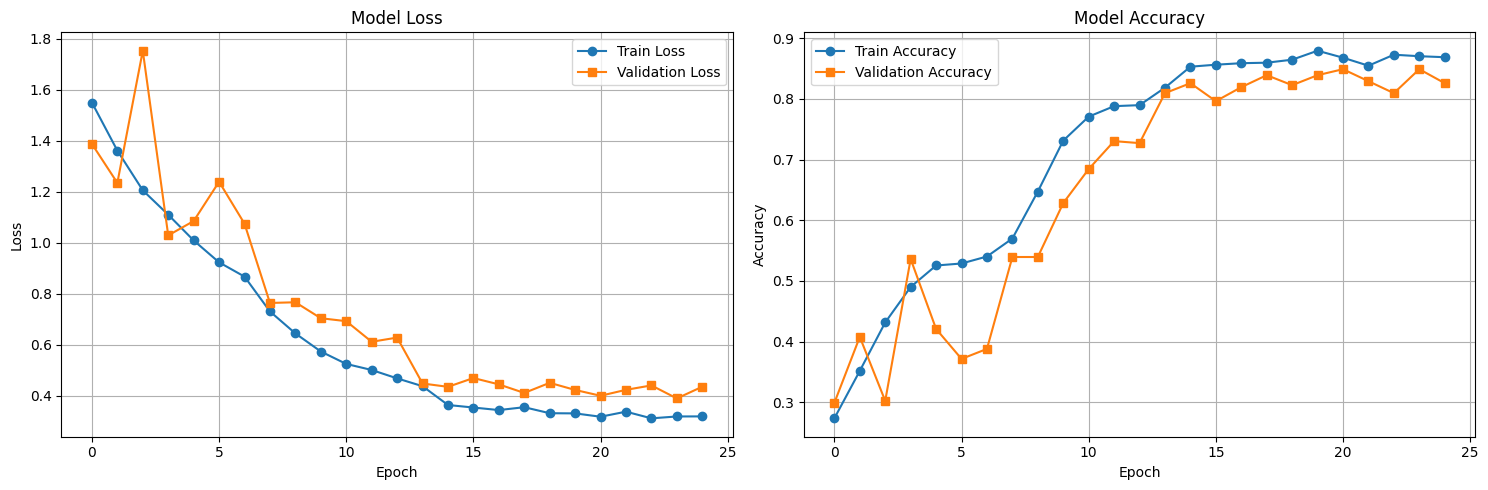

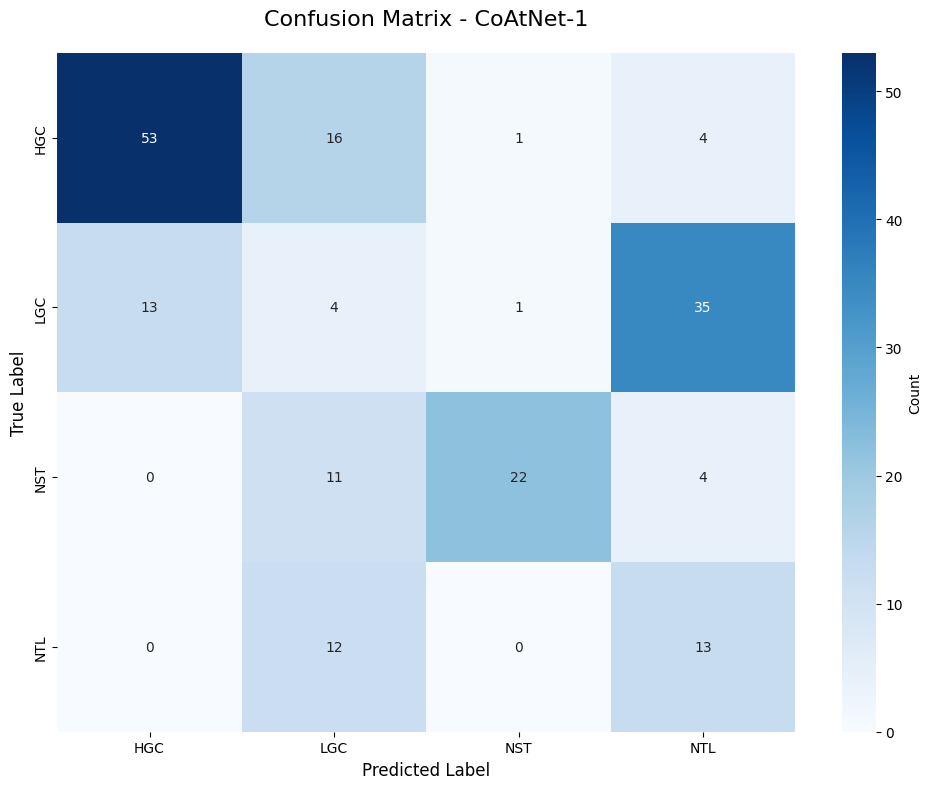

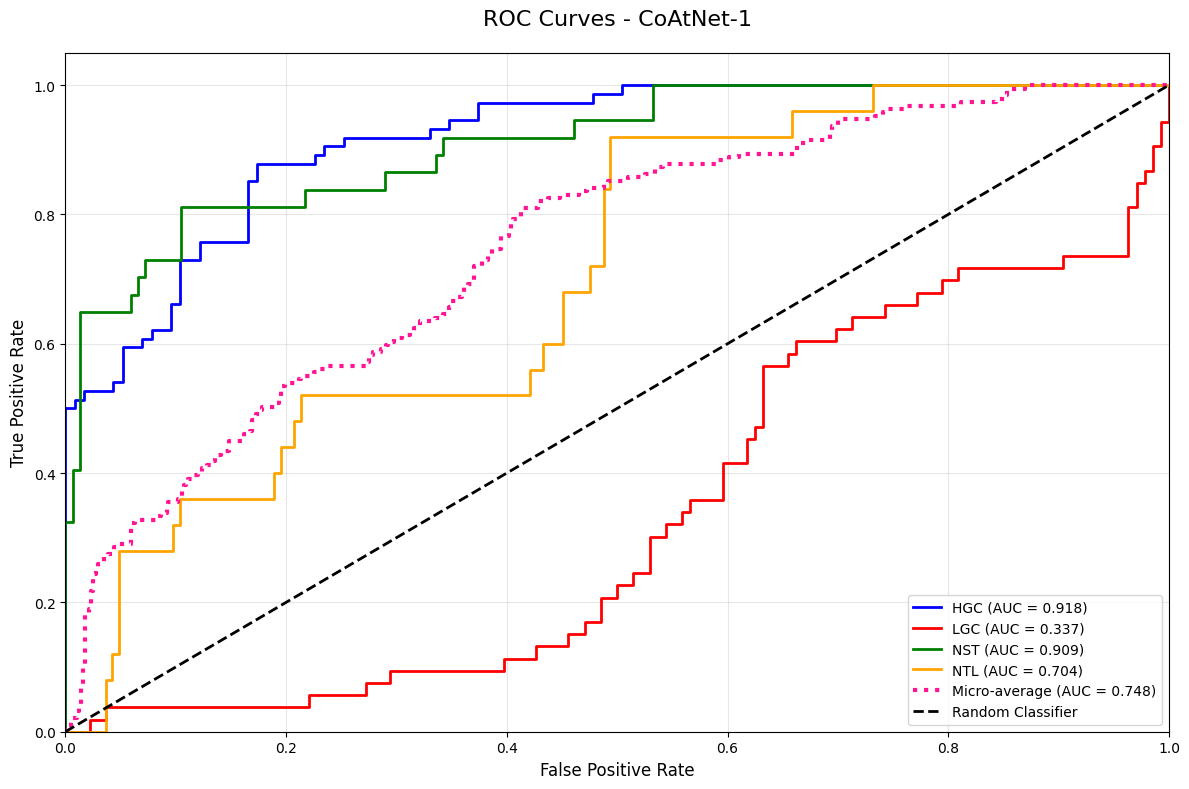


CoAtNet-1 training and evaluation complete!


In [17]:
print("=" * 80)
print("Training CoAtNet-1")
print("=" * 80)

# Create model
coatnet_1 = create_coatnet_model(
    model_type='1',
    num_classes=4,
    pretrained=True
)

# Create trainer
trainer_coatnet_1 = ModelTrainer(coatnet_1, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_coatnet_1 = trainer_coatnet_1.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="CoAtNet-1")

# Plot training history
trainer_coatnet_1.plot_training_history(save_path='coatnet_1_training_history.png')

# Evaluate model
results_coatnet_1 = trainer_coatnet_1.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_coatnet_1['confusion_matrix'], class_names, 'CoAtNet-1',
                      save_path='coatnet_1_confusion_matrix.png')

# Plot ROC curves
roc_auc_coatnet_1 = plot_roc_curves(results_coatnet_1['labels'], results_coatnet_1['probabilities'], class_names, 'CoAtNet-1',
                                     save_path='coatnet_1_roc_curves.png')

# Store results
results_coatnet_1['model_name'] = 'CoAtNet-1'
results_coatnet_1['roc_auc'] = roc_auc_coatnet_1
all_results.append(results_coatnet_1)

print("\nCoAtNet-1 training and evaluation complete!")

# Save All Metrics to CSV

In [18]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'CoAtNet_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: CoAtNet_metrics.csv

Metrics Summary:
       Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  CoAtNet-0         45.502646      2.173661             0.441708          0.454261      0.437427                0.445258             0.455026         0.442387       0.552941    0.635135  0.591195         74.0       0.138889    0.094340  0.112360         53.0       0.750000    0.567568  0.646154         37.0       0.325000        0.52  0.400000         25.0   0.680477   0.686776  0.768390  0.306604  0.840327  0.806585      0.768390      0.30